In [8]:
import matplotlib.pyplot as plt

In [1]:
"""Surface Dice metric for HuBMAP 4."""

import numpy as np
import pandas as pd
import pandas.api.types
from numba import jit
from scipy.ndimage import label, generate_binary_structure
from skimage.transform import resize
from typing import Optional, Tuple, Union


class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    rle_column_name: str,
    tolerance: float = 1.0,
    image_id_column_name: Optional[str] = None,
    slice_id_column_name: Optional[str] = None,
    resize_fraction: float = 1.0,
) -> float:
    """Mean Surface Dice over collections of 2D or 3D data.

    This metric is adapted from the Google DeepMind surface dice metric as found here:
    https://github.com/google-deepmind/surface-distance/tree/master.

    Can be used with either 2D or 3D data. When used with 3D data, each row in the solution and
    submission files should contain run-length encoded masks of a width x height slice.

    Parameters
    ----------
    solution : Pandas dataframe, the ground truth values.

    submission : Pandas dataframe, the predicted values.

    row_id_column_name : str, the name of the ID column used by Kaggle's preprocessing code to
        align the solution and submission dataframes.

    rle_column_name : str, the name of column containing run-length encoded masks.

    tolerance : float, the distance, in millimeters, the predicted mask surfaces are allowed to
        vary from the ground-truth masks.

    image_id_column_name : str (optional), for 3D data, the name of the column identifying
        the image a slice belongs to.

    slice_id_column_name : str (optional), for 3D data, the name of the column enumerating
        the slices within each image.

    resize_fraction : float, the fraction by which to resize the decoded masks. Useful for memory
        efficiency in the case of large images.

    Returns
    -------
    mean_surface_dice : float

    Examples
    --------
    No groups (2D images).
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'rle': ['1 12 20 2', '1 6'],
    ...     'width': [5, 5],
    ...     'height': [5, 5],
    ... })

    Perfect submission.
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'rle': ['1 12 20 2', '1 6'],
    ... })
    >>> score(solution, submission, 'id', 'rle', 0.0)
    1.0

    One group with two slices.
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'rle': ['1 12 20 2', '1 6'],
    ...     'width': [5, 5],
    ...     'height': [5, 5],
    ...     'group': ['a', 'a'],
    ...     'slice': [0, 1],
    ... })

    Perfect submission.
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'rle': ['1 12 20 2', '1 6'],
    ... })
    >>> score(solution, submission, 'id', 'rle', 0.0, 'group', 'slice')
    1.0

    Null submission.
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'rle': ['1 0', '1 0'],
    ... })
    >>> score(solution, submission, 'id', 'rle', 0.0, 'group', 'slice')
    0.0

    Two groups with multiple slices.
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1, 2, 3, 4],
    ...     'rle': ['1 12', '1 12 ', '1 12', '20 5', '22 2'],
    ...     'width': [5, 5, 5, 8, 8],
    ...     'height': [5, 5, 5, 4, 4],
    ...     'group': ['a', 'a', 'a', 'b', 'b'],
    ...     'slice': [0, 1, 2, 0, 1],
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1, 2, 3, 4],
    ...     'rle': ['1 12', '1 12 ', '1 12', '20 5', '22 2'],
    ... })
    >>> score(solution, submission, 'id', 'rle', 0.0, 'group', 'slice')
    1.0

    >>> submission = pd.DataFrame({
    ...     'id': [0, 1, 2, 3, 4],
    ...     'rle': ['1 11', '1 12 ', '1 13', '20 4', '22 3'],
    ... })

    With non-zero tolerance.
    >>> score(solution, submission, 'id', 'rle', 5.0, 'group', 'slice')
    1.0

    With empty masks.
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1, 2, 3, 4],
    ...     'rle': ['1 0', '1 0 ', '1 0', '1 0', '1 0'],
    ... })
    >>> score(solution, submission, 'id', 'rle', 0.0, 'group', 'slice')
    0.0
    
    Cubes, adapted from https://github.com/google-deepmind/surface-distance/blob/master/surface_distance_test.py#L307
    >>> solution = pd.DataFrame({
    ...     'id': np.arange(100),
    ...     'rle': ['1 10000' if k <= 49 else '' for k in np.arange(100)],
    ...     'width': [100] * 100,
    ...     'height': [100] * 100,
    ...     'group': ['a'] * 100,
    ...     'slice': np.arange(100),
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': np.arange(100),
    ...     'rle': ['1 10000' if k <= 50 else '' for k in np.arange(100)],
    ... })
    >>> score(solution, submission, 'id', 'rle', 0.0, 'group', 'slice')
    0.750877...

    """
    solution = solution.set_index(row_id_column_name)
    submission = submission.set_index(row_id_column_name)

    # Check that both are defined or neither are
    if (image_id_column_name is None) != (slice_id_column_name is None):
        raise ValueError("If one of `image_id_column_name` or `slice_id_column_name` is given, the other must be given also.")

    if tolerance < 0.0:
        raise ValueError("`tolerance` must be non-negative.")

    # Setup spacing_mm
    if image_id_column_name is None:
        spacing_mm = (1, 1)  # (height, width)
    else:
        spacing_mm = (1, 1, 1)  # (height, width, depth)

    # Create joined dataframe to iterate over
    joined = solution.join(submission,
                           lsuffix='_sol',
                           rsuffix='_sub')

    del submission

    # Compute surface dice for each group of slices and total
    total_dice = 0.0
    group_col = row_id_column_name if image_id_column_name is None else image_id_column_name
    for group, df in joined.groupby(group_col):
        # Make indexing easier
        df = df.reset_index(drop=True)

        # Check that we're stacking slices in order
        if image_id_column_name is not None:
            assert df.loc[:, slice_id_column_name].is_monotonic_increasing

        group_mask_sol, group_mask_sub = [], []
        height, widdth = df.loc[0, 'height'], df.loc[0, 'width']
        assert (df.loc[:, 'height'].nunique() == 1) and (df.loc[:, 'width'].nunique() == 1),\
            "Height and width must be constant within each group."

        # Decode slice RLEs to arrays
        for row in df.itertuples():
            # Mask transformation
            shape = (height, width)
            group_mask_sol.append(make_mask(row.rle_sol, shape, resize_fraction))
            group_mask_sub.append(make_mask(row.rle_sub, shape, resize_fraction))

        # Stack slices to create 3D arrays
        group_mask_sol = np.stack(group_mask_sol, axis=-1)
        assert group_mask_sol.ndim == 3
        group_mask_sub = np.stack(group_mask_sub, axis=-1)
        assert group_mask_sub.ndim == 3

        # Minimize dims: 2D or 3D
        group_mask_sol = group_mask_sol.squeeze()
        group_mask_sub = group_mask_sub.squeeze()

        # Compute surface distance
        surface_dist = compute_surface_distances(
            mask_gt=group_mask_sol,
            mask_pred=group_mask_sub,
            spacing_mm=spacing_mm,
        )
        # Compute surface dice and add to running total
        total_dice += compute_surface_dice_at_tolerance(
            surface_dist,
            tolerance_mm=tolerance,
        )

    # Compute mean from running total
    if image_id_column_name is None:
        ngroups = len(joined)
    else:
        ngroups = joined.loc[:, image_id_column_name].nunique()
    mean_surface_dice = total_dice / ngroups
    return mean_surface_dice


def make_mask(rle, shape, resize_fraction):
    if resize_fraction < 0.0 or resize_fraction > 1.0:
        raise ValueError("`resize_fraction` must be between 0.0 and 1.0, inclusive.")

    mask = rle_decode(rle, shape)
    if resize_fraction < 1.0:
        new_shape = int(shape[0] * resize_fraction), int(shape[1] * resize_fraction)
        mask = voting_resize(mask, new_shape)
    mask = mask.astype(bool)
    return mask


def voting_resize(mask, new_shape):
    interpolated_mask = resize(mask, new_shape, order=1, preserve_range=True)  # Using bilinear interpolation
    voting_mask = (interpolated_mask > 0.5).astype(np.uint8)
    return voting_mask


# Below is code from https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# Below is adapted from https://github.com/google-deepmind/surface-distance

# Copyright 2018 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS-IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# surface_distance/lookup_tables.py
"""Lookup tables used by surface distance metrics."""

import math
import numpy as np

ENCODE_NEIGHBOURHOOD_3D_KERNEL = np.array([[[128, 64], [32, 16]],
                                           [[8, 4], [2, 1]]])

# _NEIGHBOUR_CODE_TO_NORMALS is a lookup table.
# For every binary neighbour code
# (2x2x2 neighbourhood = 8 neighbours = 8 bits = 256 codes)
# it contains the surface normals of the triangles (called "surfel" for
# "surface element" in the following). The length of the normal
# vector encodes the surfel area.
#
# created using the marching_cube algorithm
# see e.g. https://en.wikipedia.org/wiki/Marching_cubes
# pylint: disable=line-too-long
_NEIGHBOUR_CODE_TO_NORMALS = [[[0, 0, 0]], [[0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]], [[-0.125, 0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125]],
                              [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
                              [[0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
                              [[-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25],
                               [-0.125, -0.125, -0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25],
                               [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375],
                               [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25]], [[0.125, -0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25],
                               [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25],
                               [0.125, 0.125, -0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375],
                               [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
                              [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125],
                               [-0.25, 0.25, -0.25]],
                              [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0],
                               [-0.25, -0.25, -0.25], [-0.125, -0.125,
                                                       -0.125]],
                              [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25],
                               [-0.125, -0.125, -0.125]],
                              [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0],
                               [-0.25, 0.25, 0.0]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
                              [[-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0],
                               [0.25, 0.25, -0.0]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25],
                               [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
                              [[-0.125, -0.125, 0.125], [-0.125, 0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25],
                               [-0.125, 0.125, -0.125],
                               [-0.125, 0.125, -0.125]],
                              [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375],
                               [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [0.25, 0.0, -0.25]],
                              [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375],
                               [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125],
                               [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375],
                               [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25],
                               [0.0, 0.25, -0.25]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
                              [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25],
                               [0.125, -0.125, -0.125]],
                              [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125],
                               [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
                              [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0],
                               [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, 0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125]], [[0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, 0.125, 0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25]],
                              [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0],
                               [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125],
                               [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
                              [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25],
                               [0.0, 0.25, -0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375],
                               [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125],
                               [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
                              [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375],
                               [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [0.25, 0.0, -0.25]],
                              [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375],
                               [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25],
                               [-0.125, 0.125, -0.125],
                               [-0.125, 0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.125, 0.125,
                                                         0.125]],
                              [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25],
                               [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
                              [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0],
                               [0.25, 0.25, -0.0]],
                              [[-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0],
                               [-0.25, 0.25, 0.0]],
                              [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25],
                               [-0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0],
                               [-0.25, -0.25, -0.25], [-0.125, -0.125,
                                                       -0.125]],
                              [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.125, -0.125, 0.125]],
                              [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
                              [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125],
                               [-0.25, 0.25, -0.25]],
                              [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375],
                               [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25],
                               [0.125, 0.125, -0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25],
                               [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
                              [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375],
                               [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25],
                               [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25],
                               [-0.125, -0.125, -0.125]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
                              [[0.125, -0.125, -0.125]],
                              [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125]],
                              [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125]], [[0, 0, 0]]]
# pylint: enable=line-too-long


def create_table_neighbour_code_to_surface_area(spacing_mm):
    """Returns an array mapping neighbourhood code to the surface elements area.

  Note that the normals encode the initial surface area. This function computes
  the area corresponding to the given `spacing_mm`.

  Args:
    spacing_mm: 3-element list-like structure. Voxel spacing in x0, x1 and x2
      direction.
  """
    # compute the area for all 256 possible surface elements
    # (given a 2x2x2 neighbourhood) according to the spacing_mm
    neighbour_code_to_surface_area = np.zeros([256])
    for code in range(256):
        normals = np.array(_NEIGHBOUR_CODE_TO_NORMALS[code])
        sum_area = 0
        for normal_idx in range(normals.shape[0]):
            # normal vector
            n = np.zeros([3])
            n[0] = normals[normal_idx, 0] * spacing_mm[1] * spacing_mm[2]
            n[1] = normals[normal_idx, 1] * spacing_mm[0] * spacing_mm[2]
            n[2] = normals[normal_idx, 2] * spacing_mm[0] * spacing_mm[1]
            area = np.linalg.norm(n)
            sum_area += area
        neighbour_code_to_surface_area[code] = sum_area

    return neighbour_code_to_surface_area.astype(np.float32)


# In the neighbourhood, points are ordered: top left, top right, bottom left,
# bottom right.
ENCODE_NEIGHBOURHOOD_2D_KERNEL = np.array([[8, 4], [2, 1]])


def create_table_neighbour_code_to_contour_length(spacing_mm):
    """Returns an array mapping neighbourhood code to the contour length.

  For the list of possible cases and their figures, see page 38 from:
  https://nccastaff.bournemouth.ac.uk/jmacey/MastersProjects/MSc14/06/thesis.pdf

  In 2D, each point has 4 neighbors. Thus, are 16 configurations. A
  configuration is encoded with '1' meaning "inside the object" and '0' "outside
  the object". The points are ordered: top left, top right, bottom left, bottom
  right.

  The x0 axis is assumed vertical downward, and the x1 axis is horizontal to the
  right:
   (0, 0) --> (0, 1)
     |
   (1, 0)

  Args:
    spacing_mm: 2-element list-like structure. Voxel spacing in x0 and x1
      directions.
  """
    neighbour_code_to_contour_length = np.zeros([16])

    vertical = spacing_mm[0]
    horizontal = spacing_mm[1]
    diag = 0.5 * math.sqrt(spacing_mm[0]**2 + spacing_mm[1]**2)
    # pyformat: disable
    neighbour_code_to_contour_length[int("00" "01", 2)] = diag

    neighbour_code_to_contour_length[int("00" "10", 2)] = diag

    neighbour_code_to_contour_length[int("00" "11", 2)] = horizontal

    neighbour_code_to_contour_length[int("01" "00", 2)] = diag

    neighbour_code_to_contour_length[int("01" "01", 2)] = vertical

    neighbour_code_to_contour_length[int("01" "10", 2)] = 2 * diag

    neighbour_code_to_contour_length[int("01" "11", 2)] = diag

    neighbour_code_to_contour_length[int("10" "00", 2)] = diag

    neighbour_code_to_contour_length[int("10" "01", 2)] = 2 * diag

    neighbour_code_to_contour_length[int("10" "10", 2)] = vertical

    neighbour_code_to_contour_length[int("10" "11", 2)] = diag

    neighbour_code_to_contour_length[int("11" "00", 2)] = horizontal

    neighbour_code_to_contour_length[int("11" "01", 2)] = diag

    neighbour_code_to_contour_length[int("11" "10", 2)] = diag
    # pyformat: enable

    return neighbour_code_to_contour_length.astype(np.float32)


# surface_distance/metrics.py
"""Module exposing surface distance based measures."""

import numpy as np
from scipy import ndimage


def _assert_is_numpy_array(name, array):
    """Raises an exception if `array` is not a numpy array."""
    if not isinstance(array, np.ndarray):
        raise ValueError("The argument {!r} should be a numpy array, not a "
                         "{}".format(name, type(array)))


def _check_nd_numpy_array(name, array, num_dims):
    """Raises an exception if `array` is not a `num_dims`-D numpy array."""
    if len(array.shape) != num_dims:
        raise ValueError("The argument {!r} should be a {}D array, not of "
                         "shape {}".format(name, num_dims, array.shape))


def _check_2d_numpy_array(name, array):
    _check_nd_numpy_array(name, array, num_dims=2)


def _check_3d_numpy_array(name, array):
    _check_nd_numpy_array(name, array, num_dims=3)


def _assert_is_bool_numpy_array(name, array):
    _assert_is_numpy_array(name, array)
    if array.dtype != bool:
        raise ValueError(
            "The argument {!r} should be a numpy array of type bool, "
            "not {}".format(name, array.dtype))


def _compute_bounding_box(mask):
    """Computes the bounding box of the masks.

  This function generalizes to arbitrary number of dimensions great or equal
  to 1.

  Args:
    mask: The 2D or 3D numpy mask, where '0' means background and non-zero means
      foreground.

  Returns:
    A tuple:
     - The coordinates of the first point of the bounding box (smallest on all
       axes), or `None` if the mask contains only zeros.
     - The coordinates of the second point of the bounding box (greatest on all
       axes), or `None` if the mask contains only zeros.
  """
    num_dims = len(mask.shape)
    bbox_min = np.zeros(num_dims, np.int64)
    bbox_max = np.zeros(num_dims, np.int64)

    # max projection to the x0-axis
    proj_0 = np.amax(mask, axis=tuple(range(num_dims))[1:])
    idx_nonzero_0 = np.nonzero(proj_0)[0]
    if len(idx_nonzero_0) == 0:  # pylint: disable=g-explicit-length-test
        return None, None

    bbox_min[0] = np.min(idx_nonzero_0)
    bbox_max[0] = np.max(idx_nonzero_0)

    # max projection to the i-th-axis for i in {1, ..., num_dims - 1}
    for axis in range(1, num_dims):
        max_over_axes = list(range(num_dims))  # Python 3 compatible
        max_over_axes.pop(axis)  # Remove the i-th dimension from the max
        max_over_axes = tuple(max_over_axes)  # numpy expects a tuple of ints
        proj = np.amax(mask, axis=max_over_axes)
        idx_nonzero = np.nonzero(proj)[0]
        bbox_min[axis] = np.min(idx_nonzero)
        bbox_max[axis] = np.max(idx_nonzero)

    return bbox_min, bbox_max


def _crop_to_bounding_box(mask, bbox_min, bbox_max):
    """Crops a 2D or 3D mask to the bounding box specified by `bbox_{min,max}`."""
    # we need to zeropad the cropped region with 1 voxel at the lower,
    # the right (and the back on 3D) sides. This is required to obtain the
    # "full" convolution result with the 2x2 (or 2x2x2 in 3D) kernel.
    # TODO:  This is correct only if the object is interior to the
    # bounding box.
    cropmask = np.zeros((bbox_max - bbox_min) + 2, np.uint8)

    num_dims = len(mask.shape)
    # pyformat: disable
    if num_dims == 2:
        cropmask[0:-1, 0:-1] = mask[bbox_min[0]:bbox_max[0] + 1,
                                    bbox_min[1]:bbox_max[1] + 1]
    elif num_dims == 3:
        cropmask[0:-1, 0:-1, 0:-1] = mask[bbox_min[0]:bbox_max[0] + 1,
                                          bbox_min[1]:bbox_max[1] + 1,
                                          bbox_min[2]:bbox_max[2] + 1]
    # pyformat: enable
    else:
        assert False

    return cropmask


def _sort_distances_surfels(distances, surfel_areas):
    """Sorts the two list with respect to the tuple of (distance, surfel_area).

  Args:
    distances: The distances from A to B (e.g. `distances_gt_to_pred`).
    surfel_areas: The surfel areas for A (e.g. `surfel_areas_gt`).

  Returns:
    A tuple of the sorted (distances, surfel_areas).
  """
    sorted_indices = np.argsort(distances)
    sorted_distances = distances[sorted_indices]
    sorted_surfel_areas = surfel_areas[sorted_indices]

    return sorted_distances, sorted_surfel_areas


def compute_surface_distances(mask_gt, mask_pred, spacing_mm):
    """Computes closest distances from all surface points to the other surface.

  This function can be applied to 2D or 3D tensors. For 2D, both masks must be
  2D and `spacing_mm` must be a 2-element list. For 3D, both masks must be 3D
  and `spacing_mm` must be a 3-element list. The description is done for the 2D
  case, and the formulation for the 3D case is present is parenthesis,
  introduced by "resp.".

  Finds all contour elements (resp surface elements "surfels" in 3D) in the
  ground truth mask `mask_gt` and the predicted mask `mask_pred`, computes their
  length in mm (resp. area in mm^2) and the distance to the closest point on the
  other contour (resp. surface). It returns two sorted lists of distances
  together with the corresponding contour lengths (resp. surfel areas). If one
  of the masks is empty, the corresponding lists are empty and all distances in
  the other list are `inf`.

  Args:
    mask_gt: 2-dim (resp. 3-dim) bool Numpy array. The ground truth mask.
    mask_pred: 2-dim (resp. 3-dim) bool Numpy array. The predicted mask.
    spacing_mm: 2-element (resp. 3-element) list-like structure. Voxel spacing
      in x0 anx x1 (resp. x0, x1 and x2) directions.

  Returns:
    A dict with:
    "distances_gt_to_pred": 1-dim numpy array of type float. The distances in mm
        from all ground truth surface elements to the predicted surface,
        sorted from smallest to largest.
    "distances_pred_to_gt": 1-dim numpy array of type float. The distances in mm
        from all predicted surface elements to the ground truth surface,
        sorted from smallest to largest.
    "surfel_areas_gt": 1-dim numpy array of type float. The length of the
      of the ground truth contours in mm (resp. the surface elements area in
      mm^2) in the same order as distances_gt_to_pred.
    "surfel_areas_pred": 1-dim numpy array of type float. The length of the
      of the predicted contours in mm (resp. the surface elements area in
      mm^2) in the same order as distances_gt_to_pred.

  Raises:
    ValueError: If the masks and the `spacing_mm` arguments are of incompatible
      shape or type. Or if the masks are not 2D or 3D.
  """
    # The terms used in this function are for the 3D case. In particular, surface
    # in 2D stands for contours in 3D. The surface elements in 3D correspond to
    # the line elements in 2D.

    _assert_is_bool_numpy_array("mask_gt", mask_gt)
    _assert_is_bool_numpy_array("mask_pred", mask_pred)

    if not len(mask_gt.shape) == len(mask_pred.shape) == len(spacing_mm):
        raise ValueError(
            "The arguments must be of compatible shape. Got mask_gt "
            "with {} dimensions ({}) and mask_pred with {} dimensions "
            "({}), while the spacing_mm was {} elements.".format(
                len(mask_gt.shape), mask_gt.shape, len(mask_pred.shape),
                mask_pred.shape, len(spacing_mm)))

    num_dims = len(spacing_mm)
    if num_dims == 2:
        _check_2d_numpy_array("mask_gt", mask_gt)
        _check_2d_numpy_array("mask_pred", mask_pred)

        # compute the area for all 16 possible surface elements
        # (given a 2x2 neighbourhood) according to the spacing_mm
        neighbour_code_to_surface_area = (
            create_table_neighbour_code_to_contour_length(spacing_mm))
        kernel = ENCODE_NEIGHBOURHOOD_2D_KERNEL
        full_true_neighbours = 0b1111
    elif num_dims == 3:
        _check_3d_numpy_array("mask_gt", mask_gt)
        _check_3d_numpy_array("mask_pred", mask_pred)

        # compute the area for all 256 possible surface elements
        # (given a 2x2x2 neighbourhood) according to the spacing_mm
        neighbour_code_to_surface_area = (
            create_table_neighbour_code_to_surface_area(spacing_mm))
        kernel = ENCODE_NEIGHBOURHOOD_3D_KERNEL
        full_true_neighbours = 0b11111111
    else:
        raise ValueError("Only 2D and 3D masks are supported, not "
                         "{}D.".format(num_dims))

    # compute the bounding box of the masks to trim the volume to the smallest
    # possible processing subvolume
    bbox_min, bbox_max = _compute_bounding_box(mask_gt | mask_pred)
    # Both the min/max bbox are None at the same time, so we only check one.
    if bbox_min is None:
        return {
            "distances_gt_to_pred": np.array([]),
            "distances_pred_to_gt": np.array([]),
            "surfel_areas_gt": np.array([]),
            "surfel_areas_pred": np.array([]),
        }

    # crop the processing subvolume.
    cropmask_gt = _crop_to_bounding_box(mask_gt, bbox_min, bbox_max)
    cropmask_pred = _crop_to_bounding_box(mask_pred, bbox_min, bbox_max)
    del mask_gt, mask_pred
    
    # compute the neighbour code (local binary pattern) for each voxel
    # the resulting arrays are spacially shifted by minus half a voxel in each
    # axis.
    # i.e. the points are located at the corners of the original voxels
    neighbour_code_map_gt = ndimage.correlate(cropmask_gt.astype(np.uint8),
                                              kernel,
                                              mode="constant",
                                              cval=0)
    neighbour_code_map_pred = ndimage.correlate(cropmask_pred.astype(np.uint8),
                                                kernel,
                                                mode="constant",
                                                cval=0)

    # create masks with the surface voxels
    borders_gt = ((neighbour_code_map_gt != 0) &
                  (neighbour_code_map_gt != full_true_neighbours))
    borders_pred = ((neighbour_code_map_pred != 0) &
                    (neighbour_code_map_pred != full_true_neighbours))

    # compute the distance transform (closest distance of each voxel to the
    # surface voxels)
    if borders_gt.any():
        distmap_gt = distance_transform_edt(~borders_gt)

    else:
        distmap_gt = np.Inf * np.ones(borders_gt.shape, np.float32)

    distances_pred_to_gt = distmap_gt[borders_pred]
    del distmap_gt

    if borders_pred.any():
        distmap_pred = distance_transform_edt(~borders_pred)

    else:
        distmap_pred = np.Inf * np.ones(borders_pred.shape, np.float32)

    distances_gt_to_pred = distmap_pred[borders_gt]
    del distmap_pred

    # compute the area of each surface element
    surface_area_map_gt = neighbour_code_to_surface_area[neighbour_code_map_gt]
    surfel_areas_gt = surface_area_map_gt[borders_gt]
    del neighbour_code_map_gt, surface_area_map_gt, borders_gt

    surface_area_map_pred = neighbour_code_to_surface_area[neighbour_code_map_pred]
    surfel_areas_pred = surface_area_map_pred[borders_pred]
    del neighbour_code_map_pred, surface_area_map_pred, borders_pred

    # sort them by distance
    if distances_gt_to_pred.shape != (0, ):
        distances_gt_to_pred, surfel_areas_gt = _sort_distances_surfels(
            distances_gt_to_pred, surfel_areas_gt)

    if distances_pred_to_gt.shape != (0, ):
        distances_pred_to_gt, surfel_areas_pred = _sort_distances_surfels(
            distances_pred_to_gt, surfel_areas_pred)

    return {
        "distances_gt_to_pred": distances_gt_to_pred,
        "distances_pred_to_gt": distances_pred_to_gt,
        "surfel_areas_gt": surfel_areas_gt,
        "surfel_areas_pred": surfel_areas_pred,
    }


def compute_surface_dice_at_tolerance(surface_distances, tolerance_mm):
    """Computes the _surface_ DICE coefficient at a specified tolerance.

  Computes the _surface_ DICE coefficient at a specified tolerance. Not to be
  confused with the standard _volumetric_ DICE coefficient. The surface DICE
  measures the overlap of two surfaces instead of two volumes. A surface
  element is counted as overlapping (or touching), when the closest distance to
  the other surface is less or equal to the specified tolerance. The DICE
  coefficient is in the range between 0.0 (no overlap) to 1.0 (perfect overlap).

  Args:
    surface_distances: dict with "distances_gt_to_pred", "distances_pred_to_gt"
      "surfel_areas_gt", "surfel_areas_pred" created by
      compute_surface_distances()
    tolerance_mm: a float value. The tolerance in mm

  Returns:
    A float value. The surface DICE coefficient in [0.0, 1.0].
  """
    distances_gt_to_pred = surface_distances["distances_gt_to_pred"]
    distances_pred_to_gt = surface_distances["distances_pred_to_gt"]
    surfel_areas_gt = surface_distances["surfel_areas_gt"]
    surfel_areas_pred = surface_distances["surfel_areas_pred"]
    overlap_gt = np.sum(surfel_areas_gt[distances_gt_to_pred <= tolerance_mm])
    overlap_pred = np.sum(
        surfel_areas_pred[distances_pred_to_gt <= tolerance_mm])
    surface_dice = (overlap_gt + overlap_pred) / (np.sum(surfel_areas_gt) +
                                                  np.sum(surfel_areas_pred))
    return surface_dice


# Below is from https://github.com/Image-Py/imagepy/blob/master/imagepy/ipyalg/hydrology/edt.py
# Copyright (c) <2016>, <ImagePy>
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
# 1. Redistributions of source code must retain the above copyright
#    notice, this list of conditions and the following disclaimer.
# 2. Redistributions in binary form must reproduce the above copyright
#    notice, this list of conditions and the following disclaimer in the
#    documentation and/or other materials provided with the distribution.
# 3. All advertising materials mentioning features or use of this software
#    must display the following acknowledgement:
#    This product includes software developed by the <organization>.
# 4. Neither the name of the <organization> nor the
#    names of its contributors may be used to endorse or promote products
#    derived from this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY <ImagePy> ''AS IS'' AND ANY
# EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL <ImagePy> BE LIABLE FOR ANY
# DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
# ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
# SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

def neighbors(shape):
    dim = len(shape)
    block = generate_binary_structure(dim, 1)
    block[tuple([1]*dim)] = 0
    idx = np.where(block>0)
    idx = np.array(idx, dtype=np.uint8).T
    idx = np.array(idx-[1]*dim)
    acc = np.cumprod((1,)+shape[::-1][:-1])
    return np.dot(idx, acc[::-1])


@jit(nopython=True)
def dist(idx1, idx2, acc):
    dis = 0
    for i in range(len(acc)):
        c1 = idx1//acc[i]
        c2 = idx2//acc[i]
        dis += (c1-c2)**2
        idx1 -= c1*acc[i]
        idx2 -= c2*acc[i]
    return dis


@jit(nopython=True)
def step(dis, pts, roots, s, level, nbs, acc, scale):
    cur = 0
    while cur<s:
        p = pts[cur]
        rp = roots[cur]
        if dis[p] == 0xffff or dis[p]>level:
            cur += 1
            continue
        for dp in nbs:
            cp = p+dp
            if dis[cp]<level*scale+2e-10:continue
            if dis[cp]==0xffff:continue
            tdist = dist(cp, rp, acc)
            if tdist<dis[cp]**2-1e-10:
                dis[cp] = (tdist**0.5)*scale
                pts[s] = cp
                roots[s] = rp
                if s == len(pts):
                    s, cur = clear(pts, roots, s, cur)
                s+=1
        pts[cur] = -1
        cur+=1
    return cur


@jit(nopython=True)
def clear(pts, roots, s, cur):
    ns = 0; nc=0;
    for c in range(s):
        if pts[c]!=-1:
            pts[ns] = pts[c]
            roots[ns] = roots[c]
            ns += 1
            if c<cur:nc += 1
    return ns, nc

        
@jit(nopython=True)
def collect(dis, nbs, pts, root):
    cur = 0
    for p in range(len(dis)):
        if dis[p]>=0xffff-1: continue # edge or back
        for dp in nbs:
            if dis[p+dp]==0xffff-1:
                pts[cur] = p
                root[cur] = p
                cur += 1
                break
    return cur


@jit(nopython=True)
def bufjit(line):
    for i in range(len(line)):
        line[i] = 1 if line[i]==0 else 0xffff


def buffer(img, dtype):
    buf = np.ones(tuple(np.array(img.shape)+2), dtype=dtype)
    buf[tuple([slice(1,-1)]*buf.ndim)] = img
    bufjit(buf.ravel())
    buf[tuple([slice(1,-1)]*buf.ndim)] -= 1
    return buf


def distance_transform_edt(img, output=np.float32, scale=1):
    dis = buffer(img, output)
    nbs = neighbors(dis.shape)
    acc = np.cumprod((1,)+dis.shape[::-1][:-1])[::-1]
    line = dis.ravel()
    pts = np.zeros(max(line.size//4, 1024**2), dtype=np.int64)
    roots = np.zeros(max(line.size//4, 1024**2), dtype=np.int64)
    s = collect(line, nbs, pts, roots)
    for level in range(10000):
        s, c = clear(pts, roots, s, 0)
        s = step(line, pts, roots, s, level, nbs, acc, scale)
        if s==0:break
    return dis[(slice(1,-1),)*img.ndim]

/tmp/ipykernel_5252/2673873397.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import numpy as np
import pandas as pd
import sys

import time
import torch
import torch.nn as nn
from PIL import Image

#sys.path.append('/kaggle/input/sennet-score/src')

di = '/root/data/'
device = torch.device('cuda')  # can be 'cpu'

# PyTorch version dependence on index data type
torch_ver_major = int(torch.__version__.split('.')[0])
dtype_index = torch.int32 if torch_ver_major >= 2 else torch.long

In [3]:
true_rle = '/root/sennet-kaggle/src/util/2d_nn/train_rles.csv'

In [4]:
# place true_rle into a dataframe
true_df = pd.read_csv(true_rle)

In [5]:
# view first 10 rows of dataframe
true_df.head(10)

# create a new datafram with only entries in column 'id' that contain 'kidney_2'
kidney_2_df = true_df[true_df['id'].str.contains('kidney_2')]


In [6]:
kidney_2_df

,id,rle
3676,kidney_2_0000,1 0
3677,kidney_2_0001,1 0
3678,kidney_2_0002,1 0
3679,kidney_2_0003,1 0
3680,kidney_2_0004,1 0
...,...,...
5888,kidney_2_2212,1 0
5889,kidney_2_2213,1 0
5890,kidney_2_2214,1 0
5891,kidney_2_2215,1 0


In [8]:
_NEIGHBOUR_CODE_TO_NORMALS = [[[0, 0, 0]], [[0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]], [[-0.125, 0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125]],
                              [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
                              [[0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
                              [[-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25],
                               [-0.125, -0.125, -0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25],
                               [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375],
                               [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25]], [[0.125, -0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25],
                               [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25],
                               [0.125, 0.125, -0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375],
                               [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
                              [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125],
                               [-0.25, 0.25, -0.25]],
                              [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0],
                               [-0.25, -0.25, -0.25], [-0.125, -0.125,
                                                       -0.125]],
                              [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25],
                               [-0.125, -0.125, -0.125]],
                              [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0],
                               [-0.25, 0.25, 0.0]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
                              [[-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0],
                               [0.25, 0.25, -0.0]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25],
                               [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
                              [[-0.125, -0.125, 0.125], [-0.125, 0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25],
                               [-0.125, 0.125, -0.125],
                               [-0.125, 0.125, -0.125]],
                              [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375],
                               [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [0.25, 0.0, -0.25]],
                              [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375],
                               [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125],
                               [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375],
                               [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25],
                               [0.0, 0.25, -0.25]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
                              [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25],
                               [0.125, -0.125, -0.125]],
                              [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125],
                               [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
                              [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0],
                               [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, 0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125]], [[0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, 0.125, 0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25]],
                              [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0],
                               [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125],
                               [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
                              [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25],
                               [0.0, 0.25, -0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375],
                               [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125],
                               [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
                              [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375],
                               [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [0.25, 0.0, -0.25]],
                              [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375],
                               [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25],
                               [-0.125, 0.125, -0.125],
                               [-0.125, 0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.125, 0.125,
                                                         0.125]],
                              [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25],
                               [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
                              [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0],
                               [0.25, 0.25, -0.0]],
                              [[-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0],
                               [-0.25, 0.25, 0.0]],
                              [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25],
                               [-0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0],
                               [-0.25, -0.25, -0.25], [-0.125, -0.125,
                                                       -0.125]],
                              [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.125, -0.125, 0.125]],
                              [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
                              [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125],
                               [-0.25, 0.25, -0.25]],
                              [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375],
                               [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25],
                               [0.125, 0.125, -0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25],
                               [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
                              [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375],
                               [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25],
                               [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25],
                               [-0.125, -0.125, -0.125]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
                              [[0.125, -0.125, -0.125]],
                              [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125]],
                              [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125]], [[0, 0, 0]]]

In [35]:
def create_table_neighbour_code_to_surface_area(spacing_mm):
    """Returns an array mapping neighbourhood code to the surface elements area.

  Note that the normals encode the initial surface area. This function computes
  the area corresponding to the given `spacing_mm`.

  Args:
    spacing_mm: 3-element list-like structure. Voxel spacing in x0, x1 and x2
      direction.
  """
    # compute the area for all 256 possible surface elements
    # (given a 2x2x2 neighbourhood) according to the spacing_mm
    neighbour_code_to_surface_area = np.zeros([256])
    for code in range(256):
        normals = np.array(_NEIGHBOUR_CODE_TO_NORMALS[code])
        sum_area = 0
        for normal_idx in range(normals.shape[0]):
            # normal vector
            n = np.zeros([3])
            n[0] = normals[normal_idx, 0] * spacing_mm[1] * spacing_mm[2]
            n[1] = normals[normal_idx, 1] * spacing_mm[0] * spacing_mm[2]
            n[2] = normals[normal_idx, 2] * spacing_mm[0] * spacing_mm[1]
            area = np.linalg.norm(n)
            sum_area += area
        neighbour_code_to_surface_area[code] = sum_area

In [34]:
def rle_decode(mask_rle: str, shape: tuple) -> np.array:
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [28]:
def compute_area(y: list, unfold: nn.Unfold, area: torch.Tensor) -> torch.Tensor:
    yy = torch.stack(y, dim=0).to(torch.float16).unsqueeze(0)
    cubes_float = unfold(yy).squeeze(0)
    cubes_byte = torch.zeros(cubes_float.size(1), dtype=dtype_index, device=device)
    
    for k in range(8):
        cubes_byte += cubes_float[k, :].to(dtype_index) << k
    
    cubes_area = area[cubes_byte]
    return cubes_area

In [41]:
def compute_surface_dice_score(submit: pd.DataFrame, label: pd.DataFrame) -> float:
    """
    Compute surface Dice score for one 3D volume

    submit (pd.DataFrame): submission file with id and rle
    label (pd.DataFrame): ground truth id, rle, and also image height, width
    """
    # submit and label must contain exact same id in same order
    assert (submit['id'] == label['id']).all()
    assert len(label) > 0

    # All height, width must be the same
    len(label['height'].unique()) == 1
    len(label['width'].unique()) == 1

    # Surface area lookup table: Tensor[float32] (256, )
    area = create_table_neighbour_code_to_surface_area((1, 1, 1))
    area = torch.from_numpy(area).to(device)  # torch.float32

    # Slide through the volume like a convolution
    unfold = torch.nn.Unfold(kernel_size=(2, 2), padding=1)

    r = label.iloc[0]
    h, w = r['height'], r['width']
    n_slices = len(label)

    # Padding before first slice
    y0 = y0_pred = torch.zeros((h, w), dtype=torch.uint8, device=device)

    num = 0     # numerator of surface Dice
    denom = 0   # denominator
    for i in range(n_slices + 1):
        # Load one slice
        if i < n_slices:
            r = label.iloc[i]
            y1 = rle_decode(r['rle'], (h, w))
            y1 = torch.from_numpy(y1).to(device)

            r = submit.iloc[i]
            y1_pred = rle_decode(r['rle'], (h, w))
            y1_pred = torch.from_numpy(y1_pred).to(device)
        else:
            # Padding after the last slice
            y1 = y1_pred = torch.zeros((h, w), dtype=torch.uint8, device=device)

        # Compute the surface area between two slices (n_cubes,)
        area_pred = compute_area([y0_pred, y1_pred], unfold, area)
        area_true = compute_area([y0, y1], unfold, area)

        # True positive cube indices
        idx = torch.logical_and(area_pred > 0, area_true > 0)

        # Surface dice numerator and denominator
        num += area_pred[idx].sum() + area_true[idx].sum()
        denom += area_pred.sum() + area_true.sum()

        # Next slice
        y0 = y1
        y0_pred = y1_pred

    dice = num / denom.clamp(min=1e-8)
    return dice.item()

In [34]:
import tifffile as tiff

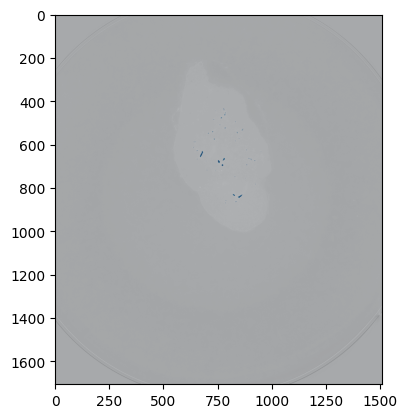

In [44]:
view_dense = tiff.imread('/root/data/train/kidney_3_dense/labels/0912.tif')
img_dense = tiff.imread('/root/data/train/kidney_3_sparse/images/0912.tif')
plt.imshow(img_dense, cmap='gray')
plt.imshow(view_dense, cmap='Blues', alpha=0.5)


In [7]:
def compute_surface_dice_score(submit: pd.DataFrame, label: pd.DataFrame) -> torch.Tensor:
    """
    Compute surface Dice score for one 3D volume

    submit (pd.DataFrame): submission file with id and rle
    label (pd.DataFrame): ground truth id, rle, and also image height, width
    """
    # submit and label must contain exact same id in same order
    assert (submit['id'] == label['id']).all()
    assert len(label) > 0

    # All height, width must be the same
    len(label['height'].unique()) == 1
    len(label['width'].unique()) == 1

    # Surface area lookup table: Tensor[float32] (256, )
    area = create_table_neighbour_code_to_surface_area((1, 1, 1))
    area = torch.from_numpy(area).to(device)  # torch.float32

    # Slide through the volume like a convolution
    unfold = torch.nn.Unfold(kernel_size=(2, 2), padding=1)

    r = label.iloc[0]
    h, w = r['height'], r['width']
    n_slices = len(label)

    # Padding before first slice
    y0 = y0_pred = torch.zeros((h, w), dtype=torch.uint8, device=device)

    # Create an empty tensor to store the slices
    slices = torch.empty((n_slices, h, w), dtype=torch.uint8, device=device)
    slices_pred = torch.empty((n_slices, h, w), dtype=torch.uint8, device=device)

    num = 0     # numerator of surface Dice
    denom = 0   # denominator
    for i in range(n_slices):
        # Load one slice
        if i < n_slices:
            r = label.iloc[i]
            y1 = rle_decode(r['rle'], (h, w))
            y1 = torch.from_numpy(y1).to(device)

            r = submit.iloc[i]
            y1_pred = rle_decode(r['rle'], (h, w))
            y1_pred = torch.from_numpy(y1_pred).to(device)
        else:
            # Padding after the last slice
            y1 = y1_pred = torch.zeros((h, w), dtype=torch.uint8, device=device)

        # Compute the surface area between two slices (n_cubes,)
        area_pred = compute_area([y0_pred, y1_pred], unfold, area)
        area_true = compute_area([y0, y1], unfold, area)

        # True positive cube indices
        idx = torch.logical_and(area_pred > 0, area_true > 0)

        # Surface dice numerator and denominator
        num += area_pred[idx].sum() + area_true[idx].sum()
        denom += area_pred.sum() + area_true.sum()

        # Store the slice in the tensor
        slices[i] = y1
        slices_pred[i] = y1_pred

        # Next slice
        y0 = y1
        y0_pred = y1_pred

    # Compute the score
    dice = num / denom.clamp(min=1e-8)

    # Print the score
    print(f"Surface Dice score: {dice.item()}")

    # Return the slices
    return slices, slices_pred


In [9]:
submit_df = '/root/sennet-kaggle/src/util/2d_nn/submission_kidney_2_surface_dice_fixed.csv'

In [10]:
submit_df = pd.read_csv(submit_df)

In [29]:
slices, slices_pred = compute_surface_dice_score(submit_df, label)

Surface Dice score: 0.7623208165168762


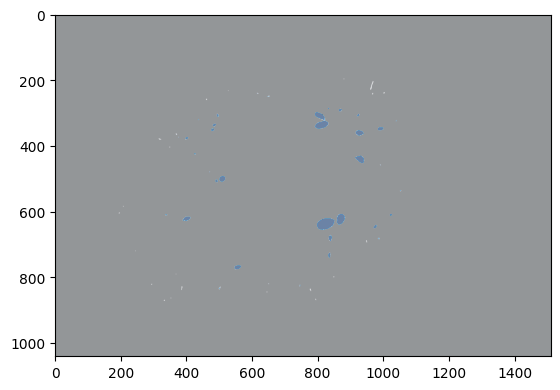

In [33]:
plt.imshow(slices[1500].cpu().numpy(), cmap='gray')
plt.imshow(slices_pred[1500].cpu().numpy(), cmap='Blues', alpha=0.6)

In [13]:
submit = "/root/sennet-kaggle/src/util/2d_nn/submission.csv"

In [20]:
# save kidney_2_df as csv file
kidney_2_df.to_csv("/root/sennet-kaggle/src/util/2d_nn/kidney_2_df.csv", index=False)

In [12]:
kidney_2_df_1 = '/root/sennet-kaggle/src/util/2d_nn/kidney_2_df.csv'

In [25]:
kidney_2 = pd.read_csv(kidney_2_df_1)

In [19]:
kidney_2

,id,rle
0,kidney_2_0000,1 0
1,kidney_2_0001,1 0
2,kidney_2_0002,1 0
3,kidney_2_0003,1 0
4,kidney_2_0004,1 0
...,...,...
2212,kidney_2_2212,1 0
2213,kidney_2_2213,1 0
2214,kidney_2_2214,1 0
2215,kidney_2_2215,1 0


In [20]:
def add_size_columns(df: pd.DataFrame):
    """
    df (DataFrame): including id column, e.g., kidney_1_dense_0000
    """
    widths = []
    heights = []
    subdirs = []
    nums = []
    for i, r in df.iterrows():
        file_id = r['id']
        subdir = file_id[:-5]    # kidney_1_dense
        file_num = file_id[-4:]  # 0000

        filename = '%s/train/%s/images/%s.tif' % (di, subdir, file_num)
        img = Image.open(filename)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        subdirs.append(subdir)
        nums.append(file_num)

    df['width'] = widths
    df['height'] = heights
    df['image_id'] = subdirs
    df['slice_id'] = nums

In [21]:
kidney_2 = add_size_columns(kidney_2)

In [26]:
image_id = 'kidney_2'
label = kidney_2
idx = label['id'].str.startswith(image_id)
label = label[idx]
label.reset_index(drop=True, inplace=True)
assert len(label) > 0
add_size_columns(label)
label.head(n=5)

,id,rle,width,height,image_id,slice_id
0,kidney_2_0000,1 0,1511,1041,kidney_2,0000
1,kidney_2_0001,1 0,1511,1041,kidney_2,0001
2,kidney_2_0002,1 0,1511,1041,kidney_2,0002
3,kidney_2_0003,1 0,1511,1041,kidney_2,0003
4,kidney_2_0004,1 0,1511,1041,kidney_2,0004


In [27]:
score = compute_surface_dice_score(submit_df, label)
score

NameError: name 'compute_area' is not defined

In [ ]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [ ]:
def make_mask(rle, shape, resize_fraction):
    if resize_fraction < 0.0 or resize_fraction > 1.0:
        raise ValueError("`resize_fraction` must be between 0.0 and 1.0, inclusive.")

    mask = rle_decode(rle, shape)
    if resize_fraction < 1.0:
        new_shape = int(shape[0] * resize_fraction), int(shape[1] * resize_fraction)
        mask = voting_resize(mask, new_shape)
    mask = mask.astype(bool)
    return mask

In [ ]:
def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    rle_column_name: str,
    tolerance: float = 1.0,
    image_id_column_name: Optional[str] = None,
    slice_id_column_name: Optional[str] = None,
    resize_fraction: float = 1.0,
) -> float:
    solution = solution.set_index(row_id_column_name)
    submission = submission.set_index(row_id_column_name)

    # Check that both are defined or neither are
    if (image_id_column_name is None) != (slice_id_column_name is None):
        raise ValueError("If one of `image_id_column_name` or `slice_id_column_name` is given, the other must be given also.")

    if tolerance < 0.0:
        raise ValueError("`tolerance` must be non-negative.")

    # Setup spacing_mm
    if image_id_column_name is None:
        spacing_mm = (1, 1)  # (height, width)
    else:
        spacing_mm = (1, 1, 1)  # (height, width, depth)

    # Create joined dataframe to iterate over
    joined = solution.join(submission,
                           lsuffix='_sol',
                           rsuffix='_sub')

    del submission


In [48]:
test_mask = rle_decode(submit_df, (1511, 1041))

AttributeError: 'DataFrame' object has no attribute 'split'